In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import kagglehub

/home/jufo/github/ml_project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
#path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

# Root directory for dataset
#dataroot = path

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3
IMAGE_CHANNELS = nc

# Size of z latent vector (i.e. size of generator input)
nz = 100
Z_DIM = nz

# Size of feature maps in generator
ngf = 64
num_generator_features = ngf

# Size of feature maps in discriminator
ndf = 64
num_discriminator_features = ndf

# Number of training epochs
num_epochs = 5
EPOCH_NUM = num_epochs

# Learning rate for optimizers
lr = 0.0002
lr_g = 0.0002
lr_d = 0.00005


# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [16]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=nz,
                out_channels=num_generator_features * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=num_generator_features * 8),
            nn.ReLU(True),
            # Size of output is kernel_size^2 * num_generator_features * 8 = 4x4x(8x64)
            nn.ConvTranspose2d(
                in_channels=num_generator_features * 8,
                out_channels=num_generator_features * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=num_generator_features * 4),
            nn.ReLU(True),
            # Size of output is kernel_size^2 * num_generator_features * 4 = 4x4x(4x64)
            nn.ConvTranspose2d(
                in_channels=num_generator_features * 4,
                out_channels=num_generator_features * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=num_generator_features * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=num_generator_features * 2,
                out_channels=num_generator_features,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=num_generator_features),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=num_generator_features,
                out_channels=IMAGE_CHANNELS,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(tensor=m.weight.data, mean=0.0, std=0.02)
    elif classname.find("Batch") != -1:
        nn.init.normal_(tensor=m.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(tensor=m.bias.data, val=0)

In [71]:
#128x128 pixel
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=nz, 
                out_channels= ngf * 16,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(
                in_channels=ngf * 16,
                out_channels=num_generator_features * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=num_generator_features * 8),
            nn.ReLU(True),
            # Size of output is kernel_size^2 * num_generator_features * 8 = 4x4x(8x64)
            nn.ConvTranspose2d(
                in_channels=num_generator_features * 8,
                out_channels=num_generator_features * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=num_generator_features * 4),
            nn.ReLU(True),
            # Size of output is kernel_size^2 * num_generator_features * 4 = 4x4x(4x64)
            nn.ConvTranspose2d(
                in_channels=num_generator_features * 4,
                out_channels=num_generator_features * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=num_generator_features * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=num_generator_features * 2,
                out_channels=num_generator_features,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=num_generator_features),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=num_generator_features,
                out_channels=nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(tensor=m.weight.data, mean=0.0, std=0.02)
    elif classname.find("Batch") != -1:
        nn.init.normal_(tensor=m.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(tensor=m.bias.data, val=0)

In [72]:
def setup() -> torch.device:
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    cudnn.benchmark = True
    return device

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

device = setup()

CUDA available: False
Device: CPU


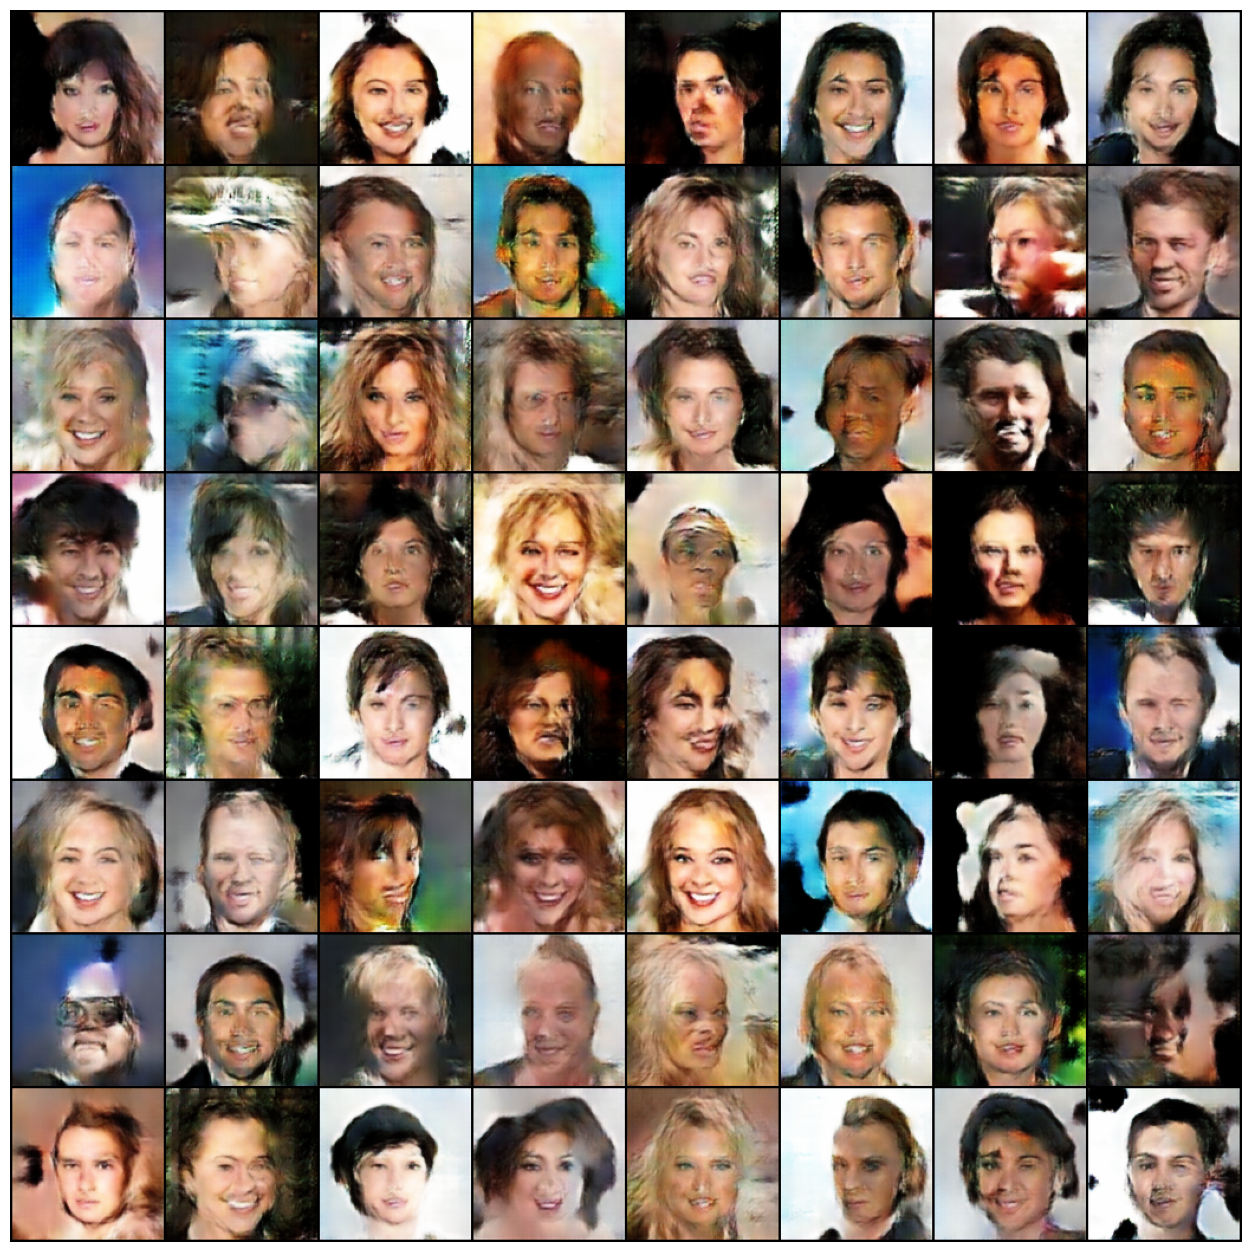

In [121]:
# show_training_data(dataloader, device)

nnGenerator = Generator(ngpu).to(device)
nnDiscriminator = Discriminator(ngpu).to(device)

fixed_noise = torch.randn(64, Z_DIM, 1, 1, device=device)

checkpoint = torch.load('dcgan_epoch_5.pth', map_location=torch.device('cpu'))
nnGenerator.load_state_dict(checkpoint['generator_state_dict'])
nnGenerator.eval()  # Set to evaluation mode

# Generate images
with torch.no_grad():
    fake_infer = nnGenerator(fixed_noise).cpu()

#img = fake_infer.to(device).cpu()
plt.figure(figsize=(16, 16))
grid = vutils.make_grid(fake_infer, normalize=True)
grid = grid.permute(1, 2, 0)
plt.imshow(grid)
plt.axis('off')
plt.show()

In [ ]:
def show_training_data(data: torch.utils.data.DataLoader, device: torch.device) -> None:
    real_batch = next(iter(data))
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training Images")
    img = np.transpose(vutils.make_grid((real_batch[0].to(device)[:64]).cpu(),normalize=True))
    plt.show()